In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None


# path = 'unseen_species_model/unseen_species_model.csv'
path = 'unseen_species_model/unseen_species_model_bayesian.csv'


df_cultura = pd.read_csv(path, index_col = [0])

# df_cultura = df_cultura.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})


df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_min']  =  df_cultura['min_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual
df_cultura['N_est_max']  =  df_cultura['max_f0'] + df_cultura['f1'] + df_cultura['f2']# plus the individual

print(len(set(df_cultura.individual_wikidata_id)))

df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
df_cultura = df_cultura[df_cultura['decade'] <=1850]

df_cultura_world = df_cultura.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_cultura_world['region_name']='world'

df_cultura = pd.concat([df_cultura_world, df_cultura])

# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)


df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']


109363


In [2]:
list(set(df_cultura['region_name']))


df_western = df_cultura[df_cultura['region_name'].isin([
                'Italy',
                'Portugal',
                'German world',
                'United Kingdom',
                'Spain',
                'Low countries',
                'France',
                'Nordic countries'])]

df_western = df_western.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_western['region_name']='Latin World'
df_western = df_western[df_western['decade']>500]
df_cultura = pd.concat([df_cultura, df_western])


df_greek_latin= df_cultura[df_cultura['region_name'].isin([
                'Latin World', 'Greek World'])]


df_greek_latin = df_greek_latin.drop('region_name', axis=1).groupby('decade').sum().reset_index()
df_greek_latin['region_name']='Greek Latin'
#df_western = df_western[df_western['decade']>500]

df_cultura = pd.concat([df_cultura, df_greek_latin])

In [3]:
# df_cultura = pd.concat([df_cultura, df_cultura_latin_after])
# df_cultura = df_cultura.reset_index(drop=True)


df_cultura_muslim= df_cultura[df_cultura['region_name'].isin(['Arabic world', 'Persian world'])]
df_cultura_muslim['region_name']='MENA'
df_cultura_muslim = df_cultura_muslim.groupby(['region_name', 'decade']).sum().reset_index()
# df_cultura_muslim = df_cultura_muslim[df_cultura_muslim['decade']>500]
df_cultura_muslim


df_cultura = pd.concat([df_cultura, df_cultura_muslim])
df_cultura = df_cultura.reset_index(drop=True)

df_pop = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/gdp_analysis/results/population_interpolated_regions.csv', index_col = [0])
df_pop['decade'] = df_pop['year'].apply(lambda x: round(x /50) * 50)
df_pop = df_pop.groupby(['region_name', 'decade'])['pop'].mean().reset_index()

# df_pop_latin_after = df_pop[df_pop['region_name'].isin(Latin_world_after)]
# df_pop_latin_after['region_name']='Latin World'
# df_pop_latin_after = df_pop_latin_after.groupby(['region_name', 'decade']).sum().reset_index()
# df_pop_latin_after = df_pop_latin_after[df_pop_latin_after['decade']>500]
# df_pop = pd.concat([df_pop, df_pop_latin_after])


df_pop_muslim = df_pop[df_pop['region_name'].isin(['Arabic world','Persian world'])]
df_pop_muslim['region_name']='MENA'
df_pop_muslim = df_pop_muslim.groupby(['region_name', 'decade']).sum().reset_index()
df_pop_muslim = df_pop_muslim[df_pop_muslim['decade']>500]

df_pop = pd.concat([df_pop, df_pop_muslim])
df_pop = df_pop.reset_index(drop=True)

pop = False
if pop is True:

    df_cultura= pd.merge(df_cultura, df_pop, on = ['region_name', 'decade'])
    df_cultura['N_est'] = df_cultura['N_est']/ df_cultura['pop']

    df_cultura['N_est'] = df_cultura['N_est']/df_cultura['pop']
    df_cultura['N_est_min'] = df_cultura['N_est_min']/df_cultura['pop']
    df_cultura['N_est_max'] = df_cultura['N_est_max']/df_cultura['pop']

    print('Population updated')

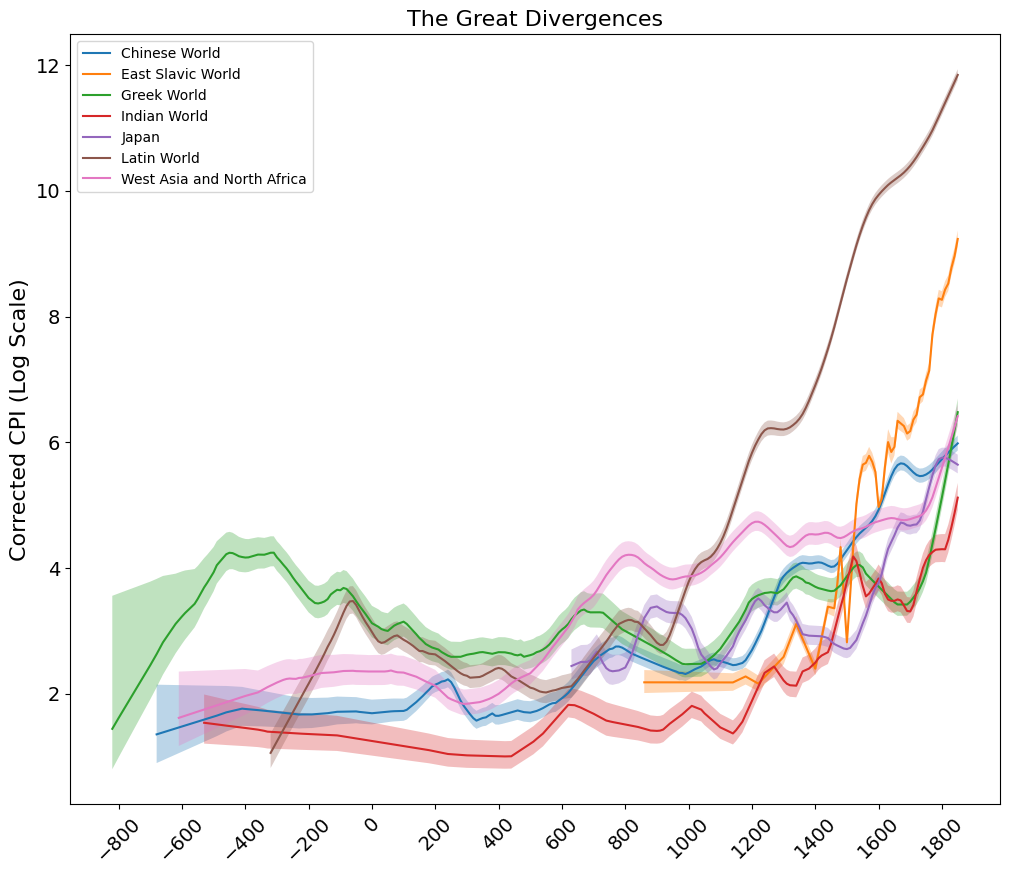

In [4]:
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

df = df_cultura.copy()
df = df_cultura[df_cultura['region_name'].isin(['Chinese world', 'Latin World', 'MENA', 'Greek World', 'Japan', 'Indian world', 'East Slavic'])]
df = df[~((df['region_name'] == 'Japan') & (df['decade'] < 600))]


df['region_name'][df['region_name']=='MENA'] = 'West Asia and North Africa'
df['region_name'][df['region_name']=='Latin world'] = 'Western Europe'
df['region_name'][df['region_name']=='East Slavic'] = 'East Slavic World'
df['region_name'][df['region_name']=='Indian world'] = 'Indian World'
df['region_name'][df['region_name']=='Chinese world'] = 'Chinese World'



# Filtering logic
df['N_est'] = np.log(df['N_est'])  # Applying log transformation
df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log


# # Define your color scheme
# colors = {
#     "Western Europe": "#00008b",
# }

fig, ax = plt.subplots(figsize=(12, 10))

# List for storing text annotations for later adjustment
texts = []

# Calculate the maximum smoothed value for normalization
max_n_est = float('-inf')

# Adding smoothing and plotting for each region
for region in df['region_name'].unique():
    region_data = df[df['region_name'] == region]
    region_data.sort_values(by='decade', inplace=True)


    n = 0.1

    # LOESS smoothing
    smoothed = lowess(region_data['N_est'], region_data['decade'], frac=n)
    smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=n)
    smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=n)

    # Update maximum n_est if current is higher
    max_n_est = max(max_n_est, max(smoothed[:, 1]))

    # Plotting the smoothed mean estimate
    ax.plot(smoothed[:, 0], smoothed[:, 1], label=region)

    # Plotting the confidence interval as a fill between
    ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], alpha=0.3)


# Set the size of x-axis and y-axis tick labels
ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

ax.set_xticks(np.arange(-800, 1801, 200))  # Set x-ticks every 200 years
# Rotating x-ticks by 45 degrees for better readability
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
ax.set_title('The Great Divergences', fontsize = 16)
ax.legend()
plt.show()


In [5]:
list(set(df_cultura['region_name']))

['Northern Japan',
 'Low countries',
 'Persian world',
 'Northern China',
 'world',
 'Spain',
 'Portugal',
 'Southern China',
 'Nordic countries',
 'Greek World',
 'German world',
 'Central Europe',
 'MENA',
 'Latin World',
 'Arabic world',
 'Indian world',
 'Southern Japan',
 'Southwestern Europe',
 'East Slavic',
 'Greek Latin',
 'Chinese world',
 'Italy',
 'France',
 'Japan',
 'United Kingdom',
 'Northwestern Europe',
 'Korea']